In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
import re
from datetime import datetime
from selenium.webdriver import ActionChains

In [132]:
#設定Chrome Driver 的執行檔路徑
options=Options()
options.chrome_executable_path="chromedriver.exe"
#登入LINE OA
driver=webdriver.Chrome(options=options)
wait = WebDriverWait(driver, 10)


In [133]:
driver.get('https://www.gap.com/browse/men/t-shirts?cid=5225&nav=meganav%3AMen%3ACategories%3AT-Shirts#pageId=0&department=75')
time.sleep(5)
driver.maximize_window()

In [76]:
driver.get('https://www.gap.com/browse/men/t-shirts?cid=5225&nav=meganav%3AMen%3ACategories%3AT-Shirts#pageId=0&department=75')
time.sleep(5)  

product_urls = []

#get the page height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # scroll to the bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    

    time.sleep(15)
    
    # get new height
    new_height = driver.execute_script("return document.body.scrollHeight")
    
    # to see if the site has reach the bottom
    if new_height == last_height:
        break  
    last_height = new_height


product_elements = driver.find_elements(By.CLASS_NAME, 'category-page-xifxib')
price_elements = driver.find_elements(By.CLASS_NAME,'product-price__strike')

product_list = []


for product,price in zip(product_elements,price_elements):
    p = product.text
    pr = price.text
    product_list.append({'product':p,'price':pr})


driver.quit()


In [134]:
scroll_step = 2000
scroll_pause_time = 5 
max_retries = 10  
last_height = driver.execute_script("return document.body.scrollHeight")

initial_product_count = 0

while True:
    # scroll the page
    driver.execute_script(f"window.scrollBy(0, {scroll_step});")
    time.sleep(scroll_pause_time)

    # get new page height
    new_height = driver.execute_script("return document.body.scrollHeight")

    # get current number of products
    current_product_elements = driver.find_elements(By.CLASS_NAME, 'category-page-xifxib')
    current_product_count = len(current_product_elements)

    # check if the number of products have changed
    if current_product_count == initial_product_count:
        print("The site might already have reached the bottom.")
        break  
    else:
        initial_product_count = current_product_count 
    
    # check if the height of the page changed
    if new_height == last_height:
        print("The site might already have reached the bottom.")
        break  
    last_height = new_height

# get all the product names and price on the page
product_elements = driver.find_elements(By.CLASS_NAME, 'category-page-xifxib')
price_elements = driver.find_elements(By.CLASS_NAME, 'product-price__strike')

product_list = []


for product, price in zip(product_elements, price_elements):
    p = product.text
    pr = price.text
    product_list.append({'product': p, 'price': pr})

driver.quit()


The site might already have reached the bottom.


In [119]:
product_df = pd.DataFrame(product_list)
product_df['price'] = product_df['price'].str.replace('$', '').astype(float)
mean_price = product_df['price'].mean()
max_price = product_df['price'].max()
min_price = product_df['price'].min()
print(f'max price: {max_price}, mean price: {mean_price}, min price:{min_price}')

max price: 44.95, mean price: 30.52142857142858, min price:19.95


In [66]:
from collections import Counter
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Function to clean the text
def clean_text(text):
    text = text.lower() 
    text = re.sub(r'[^\w\s]', '', text) 
    stop_words = set(stopwords.words('english'))  
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return words

cleaned_descriptions = [clean_text(product) for product in product_df['product'].unique()]


[nltk_data] Downloading package stopwords to /Users/hazel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
# Flatten the list of lists and count word frequency
all_words = [word for product in cleaned_descriptions for word in product]
word_counts = Counter(all_words)

# Display the most common words
print(word_counts.most_common(10))


[('graphic', 55), ('tee', 43), ('nfl', 25), ('helmet', 25), ('tshirt', 18), ('star', 6), ('wars', 6), ('gap', 6), ('logo', 5), ('new', 4)]


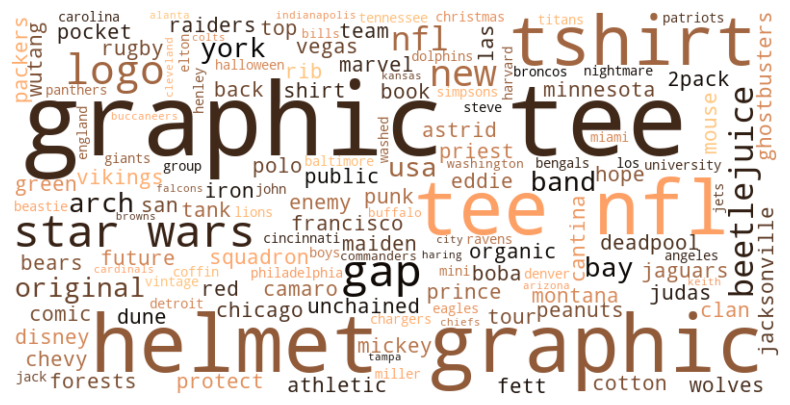

In [136]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='copper').generate(' '.join(all_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
